In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [16]:
pd.options.mode.chained_assignment = None  # default='warn'

In [17]:
df_tidy = pd.read_csv('./data/tidy.csv')
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387829 entries, 0 to 387828
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   gameID_eventID  387829 non-null  object 
 1   period          387829 non-null  int64  
 2   dateTime        387829 non-null  object 
 3   gameID          387829 non-null  int64  
 4   team            387829 non-null  object 
 5   goal            387829 non-null  bool   
 6   x               387813 non-null  float64
 7   y               387814 non-null  float64
 8   shooter         387829 non-null  object 
 9   goalie          386028 non-null  object 
 10  shotType        387780 non-null  object 
 11  emptyNet        35808 non-null   object 
 12  strength        36811 non-null   object 
 13  gameType        387829 non-null  object 
 14  home            387829 non-null  object 
 15  away            387829 non-null  object 
 16  season          387829 non-null  int64  
dtypes: bool(1)

In [18]:
"""< Det_Distance_Net. MethodMyyank>
Determine the distance to the net based on the puck's coordinates, We count the position of the x-axis to determine the teamside.
In reality about 96% are in the half near the net, so we can get team side my count coX.
:df_tidy['x']:                      column of dataframe - coordinates X
:df_tidy['y']:                      column of dataframe - coordinates Y
:leftNetCoX = -89:                  fixed value - Net coordinates
:rightNetCoX = 89:                  fixed value - Net coordinates
:return: df_tidy['distanceNet']:    new column of dataframe
"""
rink = df_tidy
rink=df_tidy.groupby(['gameID', 'team', 'period'])['x'].sum().reset_index()
rink['team_side']=np.where(rink['x'] >= 0, 'left', 'right')
rink = rink.rename(columns={'x':'sum_x'})
df_tidy1 = pd.merge(df_tidy, rink, on=['gameID', 'team', 'period'],how='left').reset_index()
   
#https://community.rapidminer.com/discussion/44904/using-the-nhl-api-to-analyze-pro-ice-hockey-data-part-1
leftNetCoX = -89
rightNetCoX = 89
df_tidy1['distanceNet'] = np.where(
    df_tidy1['team_side'] == 'right', 
    ((df_tidy['x'] - leftNetCoX)**2 + (df_tidy['y'] - 0)**2)**0.5, 
    ((df_tidy['x'] - rightNetCoX)**2 + (df_tidy['y'] - 0)**2)**0.5
    )
#print(df_tidy1) 

In [19]:
"""< DistanceNetBins. >
Divide bins according to colomn df_tidy['distanceNet']
:return: df_tidy['distanceNetBins']
"""
bins = list(range(0, 200,  10))
#print(bins)
bin_centers = list(range(5, 195,  10))
#print(bin_centers)
df_tidy1['distanceNetBins'] = pd.cut(df_tidy1['distanceNet'], bins, labels = bin_centers)

1. Produce a figure comparing the shot types over all teams (i.e. just aggregate all of the
shots), in a season of your choosing. Overlay the number of goals overtop the number of
shots. What appears to be the most dangerous type of shot? The most common type of
shot? Why did you choose this figure? Add this figure and discussion to your blog post.

      shotType   shot  goal    rate
6   Wrist Shot  41737  3681   8.82%
2    Slap Shot  13520   829   6.13%
3    Snap Shot  12733  1172   9.20%
0     Backhand   6560   698  10.64%
4       Tip-In   3980   713  17.91%
1    Deflected   1005   199  19.80%
5  Wrap-around    843    70   8.30%


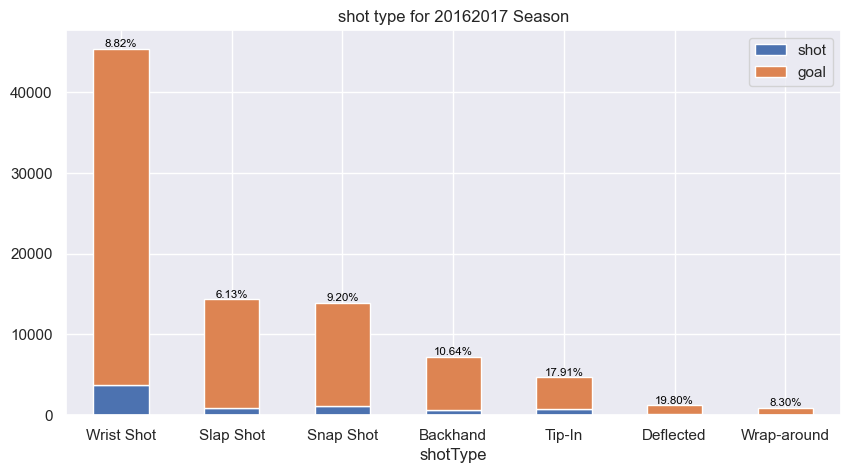

In [20]:
"""< Produce_Figure_ShotType. >
:season = 20162017:                       season choose
:df_tidy:                           full dataframe
:return:                            save figure as 5-1.png
"""
#get game_data in season 20162017

from turtle import color


season = 20162017
#df_season = df_tidy[(df_tidy['gameID'].astype('str').str[0:4] == str(year))]
df_season = df_tidy1[(df_tidy1['season'].astype('str') == str(season))]
df_season['shot'] = True
df_season1 = df_season[['shotType', 'shot', 'goal']].groupby('shotType').sum().reset_index()
df_season1['rate'] = df_season1['goal']/df_season1['shot']
df_season1['rate'] = df_season1['rate'].astype(float).map("{:.2%}".format)
df_season1.sort_values("shot",inplace=True, ascending=False)
print(df_season1)
df_season1[['shot', 'goal']] = df_season1[['goal', 'shot']]

sns.set_theme()
ax = df_season1.set_index('shotType').plot(kind='bar', stacked=True, figsize=(10,5))
ax.bar_label(ax.containers[1], labels=df_season1['rate'], color = 'black', label_type='edge', fontsize='x-small')
plt.fig = ax.get_figure()  
plt.title(f"shot type for {season} Season")
plt.xticks(rotation=0)
plt.show()
if not os.path.exists("./images/output"):
        os.makedirs("./images/output")
plt.fig.savefig("./images/output/5-1"+".png", bbox_inches = 'tight')


2. What is the relationship between the distance a shot was taken and the chance it was a
goal? Produce a figure for each season between 2018-19 to 2020-21 to answer this,
and add it to your blog post along with a couple of sentences describing your figure. Has
there been much change over the past three seasons? Why did you choose this figure?

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


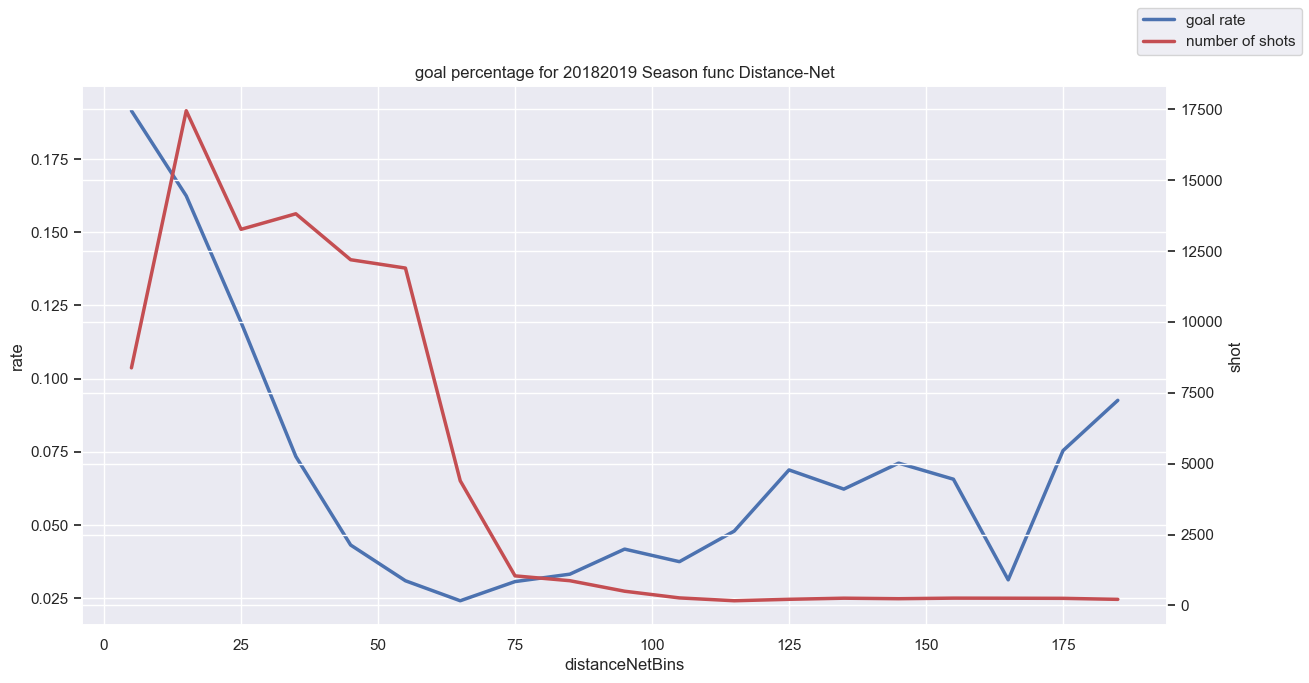

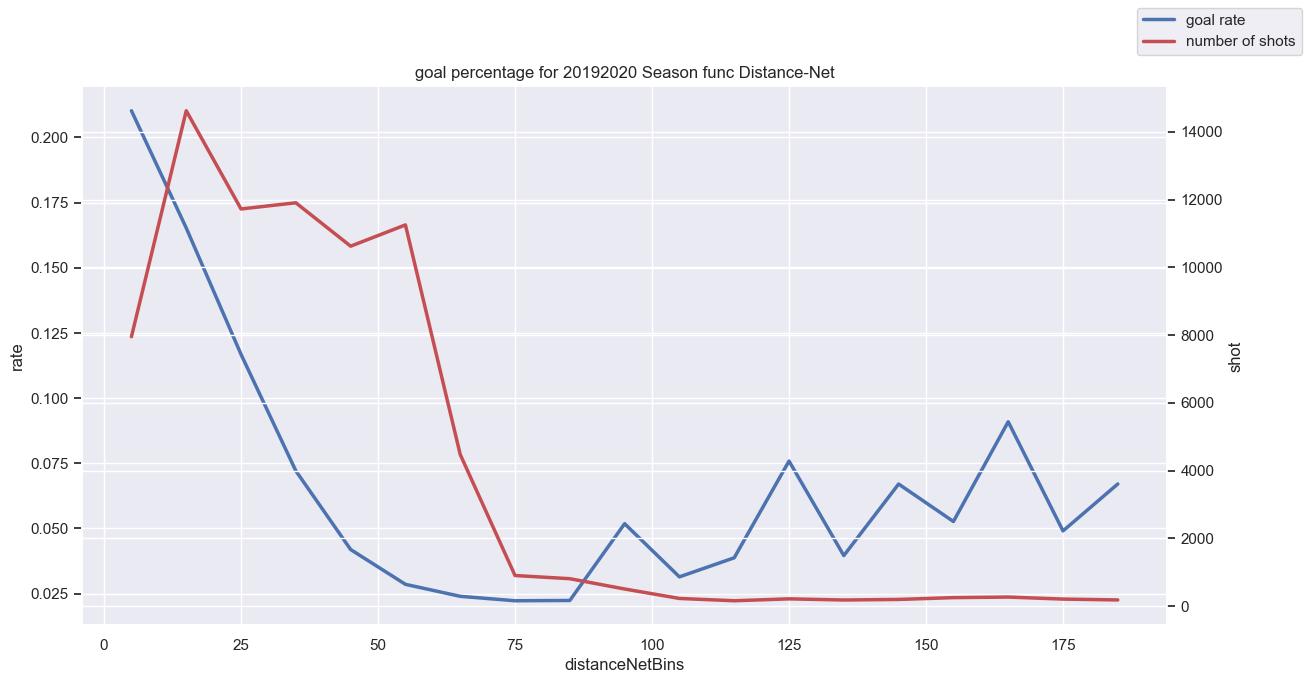

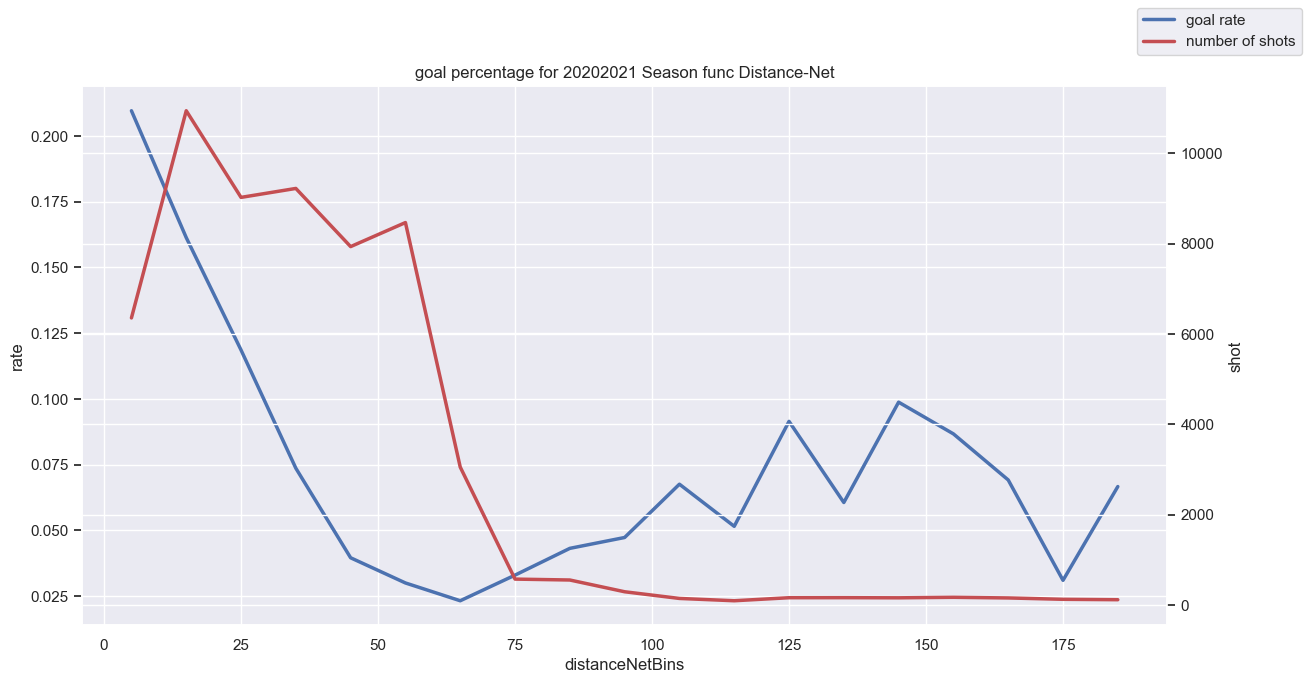

In [21]:
"""< Produce_Figure_GoalRate/Distance. >
:seasons = [20182019, 20192020, 20202021]:      season list
:df_tidy:                                       full dataframe
:return:                                        save figures as 5-2 {year}.png
"""
seasons = [20182019, 20192020, 20202021]

#print(df_1819_2021.sample(10))
for season in seasons:
    #df_year = df_1819_2021[(df_1819_2021['gameID'].astype('str').str[0:4] == str(year))]
    df_season2 = df_tidy1[(df_tidy1['season'].astype('str') == str(season))]
    df_season2['shot'] = True
    df_season2 = df_season2[['distanceNetBins', 'shot', 'goal' ]].groupby(['distanceNetBins']).sum().reset_index()
    df_season2['rate'] = df_season2['goal']/df_season2['shot']
    #print(df_1819_2021.sample(10))

    fig = plt.figure(figsize = (14,7))
    ax = sns.lineplot(x = 'distanceNetBins', y = 'rate', label='goal rate', data = df_season2, color='b', legend = False, linewidth = 2.5)
    ax2 = plt.twinx()
    ax2 = sns.lineplot(x = 'distanceNetBins', y = 'shot', label='number of shots', data = df_season2, color='r', legend = False, linewidth = 2.5)
    plt.title(f"goal percentage for {season} Season func Distance-Net")
    fig.legend(loc="upper right")
    plt.autoscale()
    fig.show()
    fig.savefig("./images/output/5-2"+str(season)+".png", bbox_inches = 'tight')
    

3. Combine the information from the previous sections to produce a figure that shows the
goal percentage (# goals / # shots) as a function of both distance from the net, and the
category of shot types (you can pick a single season of your choice). Briefly discuss
your findings; e.g. what might be the most dangerous types of shots?

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


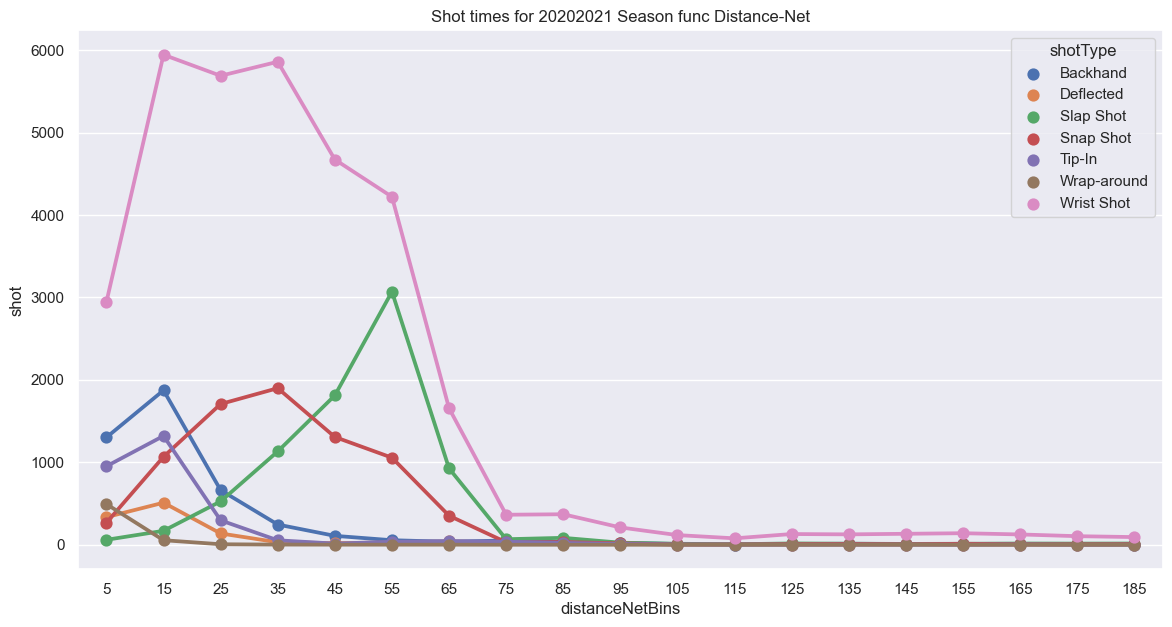

In [22]:
"""< Produce_Figure_GoalRate/Distance. >
First produce a shot count graph for ShotType with distance as X axis.
:seasons_q3 = 20202021:                       season choose
:df_tidy:                           full dataframe
:return:                            save figures as 5-2 nbshot {year_q3}.png
"""

seasons_q3 = 20202021
#df_year = df_tidy[(df_tidy['gameID'].astype('str').str[0:4] == str(year_q3))]
df_season3 = df_tidy1[(df_tidy1['season'].astype('str') == str(seasons_q3))]
#df_20162017_3.head()

df_season3['shot'] = True
df_season3_1 = df_season3[['shotType','distanceNetBins', 'shot', 'goal' ]].groupby(['shotType', 'distanceNetBins']).sum().reset_index()
df_season3_1['rate'] = df_season3_1['goal']/df_season3_1['shot']

#the most accurate type of shot in hockey - WristShot, slap shot, snap shot
fig = plt.figure(figsize = (14,7))
ax = sns.pointplot(x="distanceNetBins", y="shot", hue="shotType", data=df_season3_1)
plt.title(f"Shot times for {seasons_q3} Season func Distance-Net")
fig.show()
fig.savefig("./images/output/5-3"+"nbShot"+str(seasons_q3)+".png", bbox_inches = 'tight')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


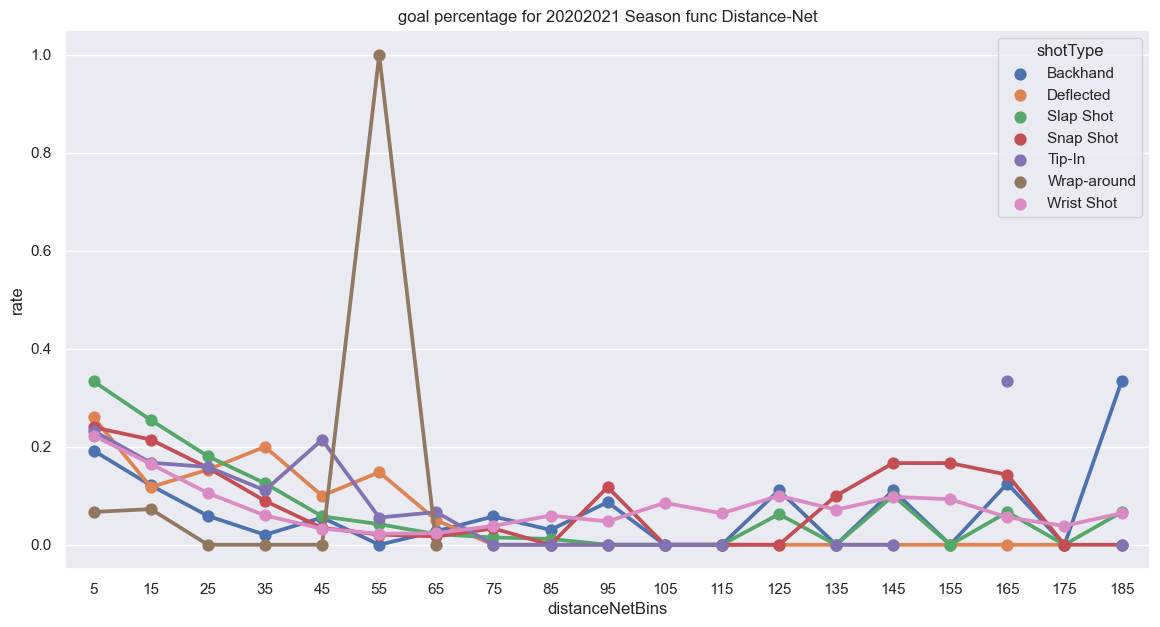

In [23]:
"""< Produce_Figure_GoalRate/Distance. >
Second "Try" produce a goalRate graph for ShotType with distance as X axis.
:seasons_q3 = 20202021:             season choose
:df_tidy:                           full dataframe
:return:                            save figures as 5-2 nbshot {year_q3}.png
<error/Noise> The shots count for some ShotType at some specific distances is too low, but GoalRate is high.
"""
fig = plt.figure(figsize = (14,7))
ax = sns.pointplot(x="distanceNetBins", y="rate", hue="shotType", data=df_season3_1)
plt.title(f"goal percentage for {seasons_q3} Season func Distance-Net")
fig.show()
fig.savefig("./images/output/5-3"+"goalRate"+str(seasons_q3)+".png", bbox_inches = 'tight')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


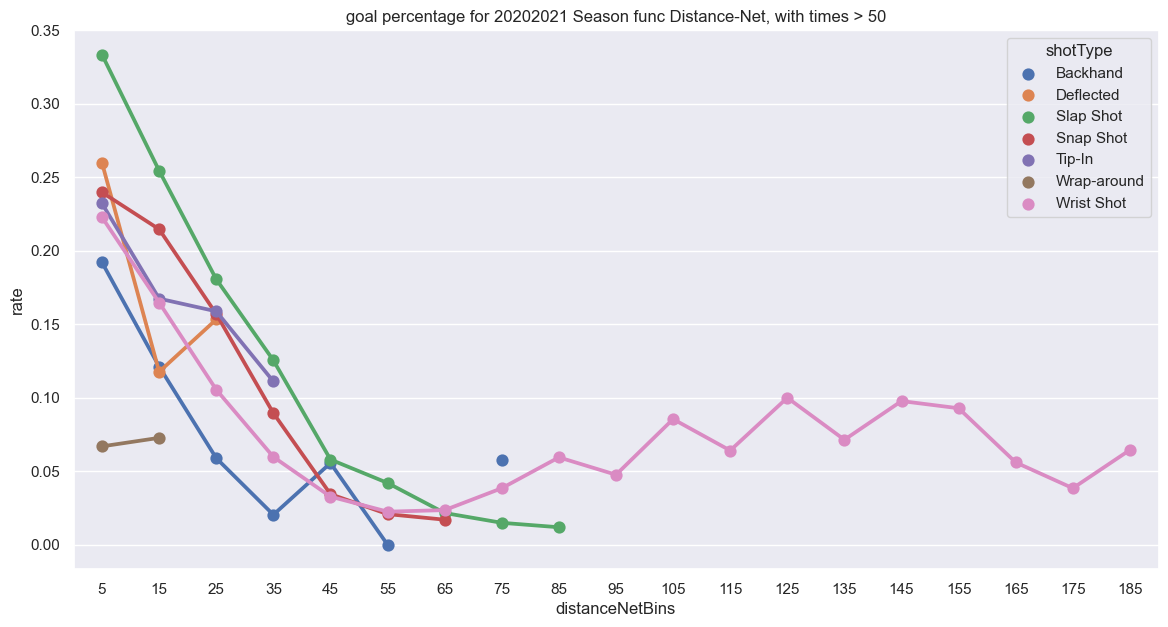

In [24]:
"""< Produce_Figure_GoalRate/Distance. >
Third produce a goalRate graph for ShotType with distance as X axis without Noise
:min_sample_size = 50:              filter out some shotType in some distance when number of shot too small
:seasons_q3 = 20202021:             season choose
:df_tidy:                           full dataframe
:return:                            save figures as 5-2 nbshot {year_q3}.png
<error> The shots count for some ShotType at some specific distances is too low, but GoalRate is high.
"""
min_sample_size = 50
df_season3_1 = df_season3_1[df_season3_1['shot'] > min_sample_size]
df_season3_1['rate'] = df_season3_1['goal']/df_season3_1['shot']
#print(df_year_q3.head(20))

fig = plt.figure(figsize = (14,7))
ax = sns.pointplot(x="distanceNetBins", y="rate", hue="shotType", data=df_season3_1)
plt.title(f"goal percentage for {seasons_q3} Season func Distance-Net, with times > 50")
fig.show()
fig.savefig("./images/output/5-3"+"goalRate&50+"+str(seasons_q3)+".png", bbox_inches = 'tight')